<a href="https://colab.research.google.com/github/angelinakhatiwada/Rainfall-prediction/blob/main/Rainfall_by_country_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Rainfall by region in 1990-2019**
September 2022

Angelina Khatiwada






### Installing and importing Libraries

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.graph_objects as go
from pandas import to_datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
import tqdm
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

plt.style.use('seaborn')
warnings.simplefilter(action='ignore')

In [ ]:
def missing_value_check(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df

In [ ]:
# Importing data
rainfall = pd.read_csv('rainfall_by_country.csv')

### Exploratory analysis

In [ ]:
print(rainfall.shape)
rainfall.head()

(265620, 5)


,AdminCode,mean_rainfall,year,month,decade
0,273,1.613,1990,1,1
1,274,103.433,1990,1,1
2,276,140.389,1990,1,1
3,277,61.144,1990,1,1
4,278,0.000,1990,1,1


In [ ]:
# missing values check
missing_value_check(rainfall)

,column_name,percent_missing
AdminCode,AdminCode,0.0
mean_rainfall,mean_rainfall,0.0
year,year,0.0
month,month,0.0
decade,decade,0.0


In [ ]:
# removing possible duplicates
rainfall_df = rainfall.drop_duplicates().reset_index(drop = True)
print(rainfall_df.shape)

(264554, 5)


In [ ]:
print(len(rainfall_df.AdminCode.unique())) # number of unique admin areas
rainfall_df.AdminCode.value_counts()

245


134     1080
173     1080
178     1080
179     1080
180     1080
        ... 
1018    1078
1019    1078
272     1078
275     1078
273     1078
Name: AdminCode, Length: 245, dtype: int64

In [ ]:
# creating dates of out decades
conditions = [
    (rainfall_df.decade == 1),
    (rainfall_df.decade == 2),
    (rainfall_df.decade == 3)
    ]

# assigning days (1 days of the month for the 1st decade; 11th day - for the second; 21 - for the third)
values = [1, 11, 21]

# creating new columns
rainfall_df['day'] = np.select(conditions, values)
rainfall_df['date']=pd.to_datetime(rainfall_df[['year','month','day']])

rainfall_df.tail()

,AdminCode,mean_rainfall,year,month,decade,day,date
264549,61013,6.176,2019,12,3,21,2019-12-21
264550,70001,0.955,2019,12,3,21,2019-12-21
264551,147296,32.848,2019,12,3,21,2019-12-21
264552,147297,38.120,2019,12,3,21,2019-12-21
264553,147299,12.894,2019,12,3,21,2019-12-21


In [ ]:
# dates check
earliest_date = min(rainfall_df.date)
latest_date = max(rainfall_df.date)
print(earliest_date,latest_date )

1990-01-01 00:00:00 2019-12-21 00:00:00


In [ ]:
# keeping admincode, mean_rainfall and date columns
df = rainfall_df.drop(["year","month","decade", "day"], axis=1)

In [ ]:
statistics = df.groupby('AdminCode').describe().reset_index()

In [ ]:
print(statistics.loc[statistics['mean_rainfall']['std'].idxmax()])
print(statistics.loc[statistics['mean_rainfall']['std'].idxmin()])

print(statistics.loc[statistics['mean_rainfall']['mean'].idxmax()])
print(statistics.loc[statistics['mean_rainfall']['mean'].idxmin()])

AdminCode                252.000000
mean_rainfall  count    1080.000000
               mean      104.078704
               std        83.644218
               min         3.000000
               25%        48.000000
               50%        81.500000
               75%       137.500000
               max       652.000000
Name: 191, dtype: float64
AdminCode               40762.000000
mean_rainfall  count     1080.000000
               mean         0.007072
               std          0.044752
               min          0.000000
               25%          0.000000
               50%          0.000000
               75%          0.000000
               max          0.662000
Name: 236, dtype: float64
AdminCode                252.000000
mean_rainfall  count    1080.000000
               mean      104.078704
               std        83.644218
               min         3.000000
               25%        48.000000
               50%        81.500000
               75%       137.500000
   

In [ ]:
df.mean_rainfall.describe() #summary statistics for the global data

count    264554.000000
mean         32.269244
std          40.421399
min          -1.000000
25%           5.150000
50%          17.920000
75%          44.435750
max         668.000000
Name: mean_rainfall, dtype: float64

In [ ]:
# Data outliers by mean rainfall monthly

df_mean_by_area_month = rainfall_df.groupby(['AdminCode', 'month'])['mean_rainfall'].mean().reset_index()
df_mean_by_area_month.head()

fig = go.Figure(
    go.Box(boxpoints='suspectedoutliers',
           x = df_mean_by_area_month['month'],
           y=df_mean_by_area_month["mean_rainfall"], text=df_mean_by_area_month["AdminCode"]))

fig.update_layout(
    xaxis_title="Months",
    yaxis_title="mean_rainfall mm")

fig.show(renderer="colab")

# To see the chart please refer to the Google Colab page

In [ ]:
#admin codes with negative value of the rainfall
df[df.mean_rainfall <0].AdminCode.value_counts()

134    1078
216    1078
255     250
56        1
Name: AdminCode, dtype: int64

          mean_rainfall                                                 \
                  count        mean        std    min     25%      50%   
AdminCode                                                                
134              1080.0   -0.832407   3.892695 -1.000  -1.000  -1.0000   
252              1080.0  104.078704  83.644218  3.000  48.000  81.5000   
273              1078.0   58.760092  60.261986  0.655   4.931  29.1735   
40762            1080.0    0.007072   0.044752  0.000   0.000   0.0000   

                               
                 75%      max  
AdminCode                      
134         -1.00000   89.538  
252        137.50000  652.000  
273        110.16275  270.789  
40762        0.00000    0.662  
252


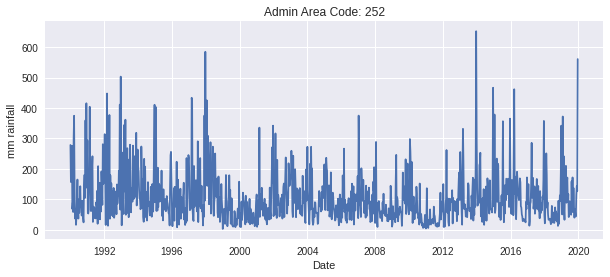

134


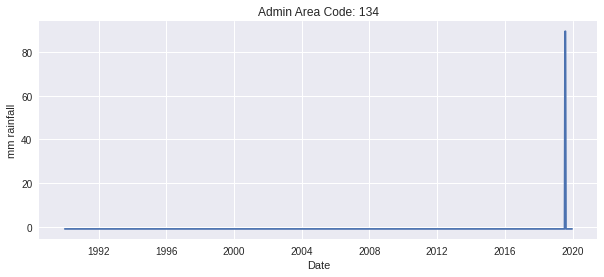

40762


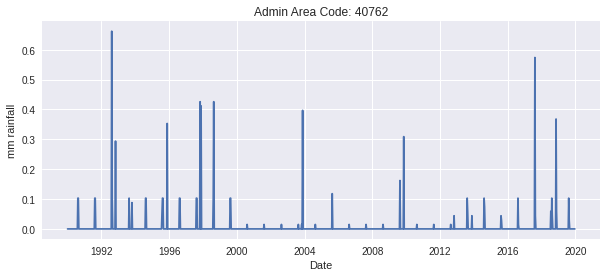

273


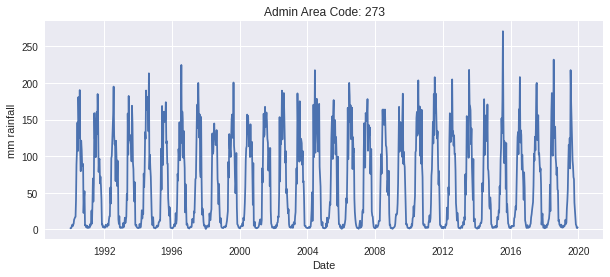

In [ ]:
list_examples = [252, 134, 40762, 273]
df_admin_code= df[df.AdminCode.isin(list_examples)]
print(df_admin_code.groupby('AdminCode').describe())

for i in list_examples:
    example_df = df_admin_code[df_admin_code.AdminCode == i]
    
    print(i)

    plt.figure(figsize=(10,4))
    plt.ylabel('mm rainfall')
    plt.xlabel('Date')
    plt.title("Admin Area Code: %.f" % i)   

    plt.plot(example_df.date, example_df.mean_rainfall)
    plt.show()


### Prophet model

In [ ]:
# renaming columns in Prophet format
df = df.reset_index(drop =True)
df = df.rename(columns={'date': 'ds',
                                'mean_rainfall': 'y'})

df.head()

,AdminCode,y,ds
0,273,1.613,1990-01-01
1,274,103.433,1990-01-01
2,276,140.389,1990-01-01
3,277,61.144,1990-01-01
4,278,0.000,1990-01-01


In [ ]:
## FUNCTIONS

# define train/test
def train_test(date_cutoff, df):
  df_train = df[df.ds < date_cutoff]
  df_test = df[df.ds >= date_cutoff]

  return df_train, df_test

# define forecast period
def forecast_period(y_start, y_end, m_start, m_end):

  forecast_period = list()
  for y in range (y_start,y_end):
    for m in range(m_start, m_end):
      for day in [1, 11, 21]:
        date = '%02d-%02d-%02d' % (y, m, day)
        forecast_period.append(date)

  return forecast_period

# define evaluation metrics
def model_evaluation(forecast_true_df):

  mae = mean_absolute_error(forecast_true_df['y'], forecast_true_df['yhat'])
  mse = mean_squared_error(forecast_true_df['y'], forecast_true_df['yhat'])
  rmse = math.sqrt(mse)

  return mae, mse, rmse

def plots_model(model, forecast, area_code):

  # model 
  model.plot(forecast, uncertainty=True, figsize=(10, 4))
  plt.title("Admin Area Code: %.f" % area_code)
  plt.show()

def plots_model_components(model, forecast,area_code):

  # model components
  fig=model.plot_components(forecast)
  plt.title("Admin Area Code: %.f" % area_code)
  plt.show()

def plots_model_test(forecast_true, area_code):

  # plot expected vs actual for test set
  plt.figure(figsize=(10,4))
  plt.plot(forecast_true['ds'], forecast_true['y'], label='Actual')
  plt.plot(forecast_true['ds'], forecast_true['yhat'], label='Predicted')
  plt.ylabel('mm rainfall')
  plt.xlabel('Date')  
  plt.title("Admin Area Code: %.f" % area_code)
  plt.legend()
  plt.show()


#### Testing (prediction for 2016-2019)

In [ ]:
# TESTING FUNCTION

def testing_prophet_model(df, date_cutoff, area_code, future, plots):

  example = df[df.AdminCode == area_code][['ds', 'y']]

  train, test = train_test(date_cutoff, example)
  
  model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

  # fit the model
  model.fit(train)

  # forecasting 
  future = pd.DataFrame(future)
  future.columns = ['ds']
  future['ds'] = to_datetime(future['ds'])

  forecast = model.predict(future)

  # define test_future
  forecast_true = forecast.merge(test, on='ds', how='inner') # inner join to remove cases where not all the values are present and keeping just test

  mae, mse, rmse = model_evaluation(forecast_true)

  if plots == True:
    print('MAE: %.3f' % mae)
    print('RMSE: %.3f' % rmse)

    plots_model(model, forecast, area_code)
    plots_model_components(model, forecast, area_code)
    plots_model_test(forecast_true, area_code)

  return mae, rmse


In [ ]:
## Defining parameters for testing

date_cutoff = '2016-01-01' # train/test cutoff

future = forecast_period(1990,2020,1,13) # define the period for prediction (includes both train and test)

  0%|          | 0/4 [00:00<?, ?it/s]

Area code: 252
MAE: 73.957
RMSE: 89.236


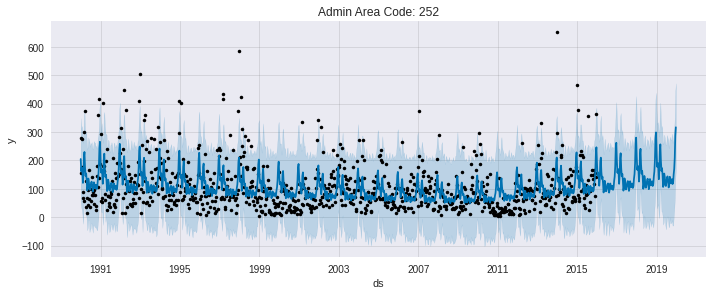

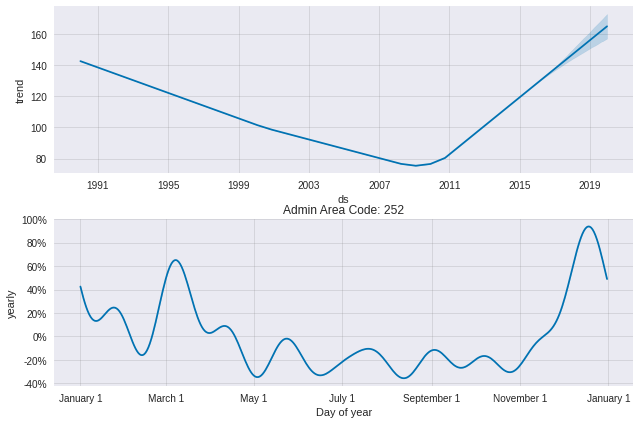

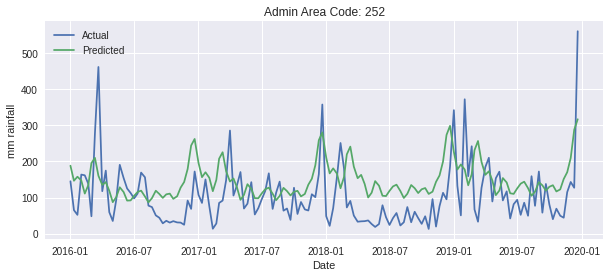

 25%|██▌       | 1/4 [00:12<00:37, 12.47s/it]

Area code: 134
MAE: 1.257
RMSE: 10.666


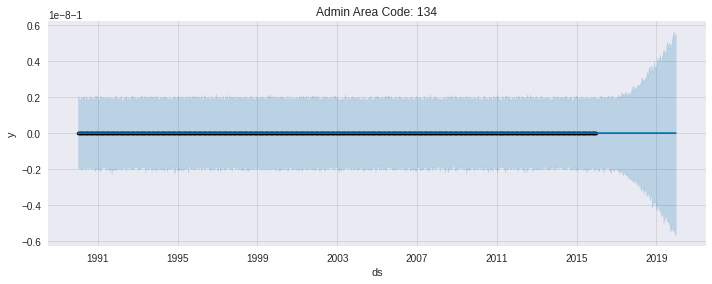

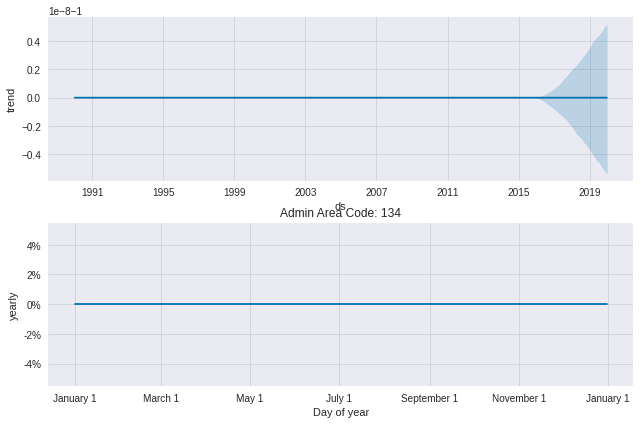

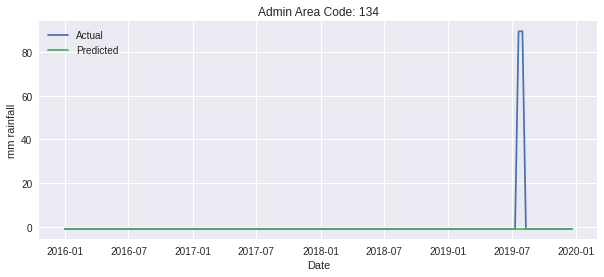

 50%|█████     | 2/4 [00:23<00:23, 11.88s/it]

Area code: 40762
MAE: 0.012
RMSE: 0.054


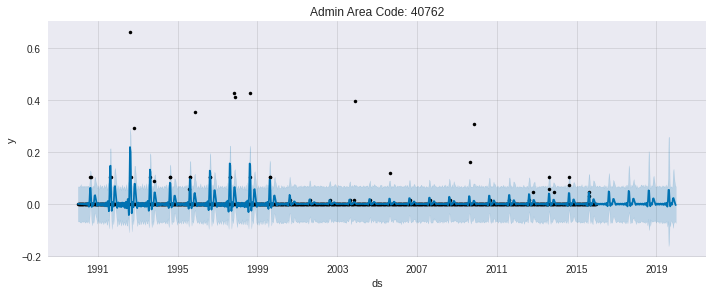

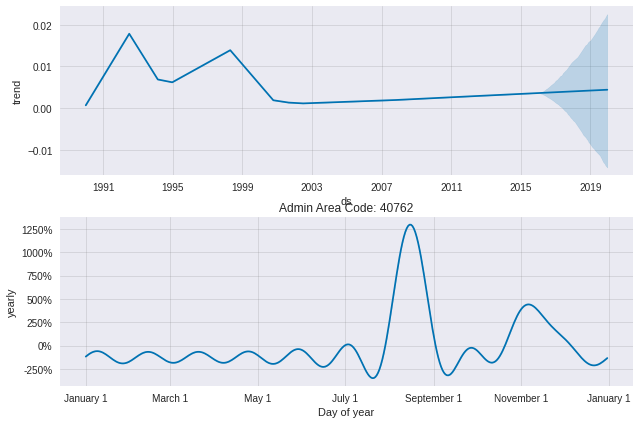

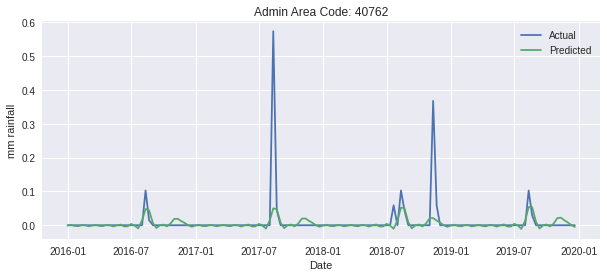

 75%|███████▌  | 3/4 [00:34<00:11, 11.36s/it]

Area code: 273
MAE: 12.418
RMSE: 19.571


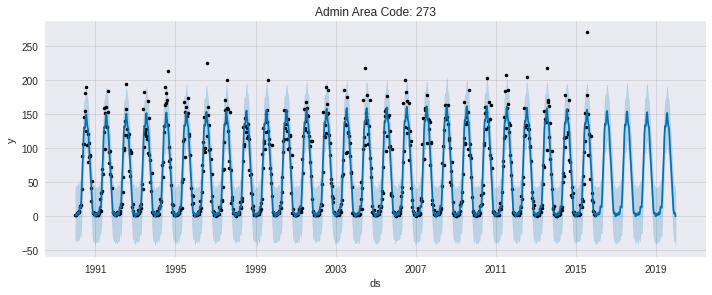

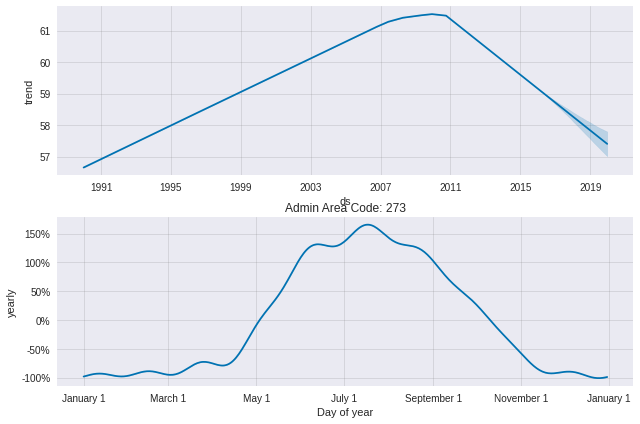

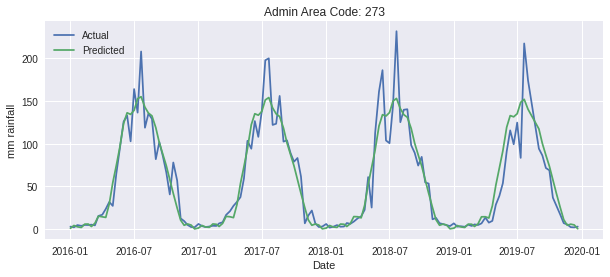

100%|██████████| 4/4 [00:39<00:00,  9.88s/it]


In [ ]:
# testing and plotting for selected examples

example_area_codes = [252, 134, 40762, 273]

for area_code in tqdm.tqdm(example_area_codes):
  print('Area code: %.f' % area_code)
  mae, rmse = testing_prophet_model(df, date_cutoff, area_code, future, plots = True)  

In [ ]:
# testing for all the areas and creating df with scores

area_codes_list = df.AdminCode.unique()

list_mae, list_rmse = [], []

for area_code in tqdm.tqdm(area_codes_list):
  mae, rmse = testing_prophet_model(df, date_cutoff, area_code, future, plots = False)
  list_mae.append(mae)
  list_rmse.append(rmse)

test_scores_df = pd.DataFrame(
    {'area_code': area_codes_list,
     'mae': list_mae,
     'rmse': list_rmse
    })

100%|██████████| 245/245 [14:35<00:00,  3.57s/it]


In [ ]:
print(test_scores_df.head())
print(test_scores_df[['mae', 'rmse']].describe()) # global test scores statistics

   area_code        mae       rmse
0        273  12.418345  19.570670
1        274  17.570643  22.075555
2        276  37.648328  58.397636
3        277  44.756034  57.727798
4        278   5.132583  10.642769
              mae        rmse
count  245.000000  245.000000
mean    13.817502   20.090146
std     11.733332   16.663225
min      0.012423    0.053824
25%      6.319687    9.031800
50%     10.859045   15.742624
75%     17.697909   25.876654
max     73.957055  110.344532


In [ ]:
print(test_scores_df.loc[test_scores_df['rmse'].idxmax()])
print(test_scores_df.loc[test_scores_df['rmse'].idxmin()])

print(test_scores_df.loc[test_scores_df['mae'].idxmax()])
print(test_scores_df.loc[test_scores_df['mae'].idxmin()])

area_code     54.000000
mae           64.965862
rmse         110.344532
Name: 69, dtype: float64
area_code    40762.000000
mae              0.012423
rmse             0.053824
Name: 236, dtype: float64
area_code    252.000000
mae           73.957055
rmse          89.235788
Name: 215, dtype: float64
area_code    40762.000000
mae              0.012423
rmse             0.053824
Name: 236, dtype: float64


#### Predicting (2020)

In [ ]:
## Predicting for the new datapoints

def predicting_prophet_model(df, area_code, future, date1, date2, plots):

  example = df[df.AdminCode == area_code][['ds', 'y']]

  model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

  # fit the model
  model.fit(example)

  # forecasting the future (2016-2020)
  future = pd.DataFrame(future)
  future.columns = ['ds']
  future['ds'] = to_datetime(future['ds'])

  forecast = model.predict(future)

  forecast_true = forecast.merge(example, on='ds', how='left') 

  if plots == True:
    plots_model(model, forecast, area_code)
  
    forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(10,4), xlim=(date1, date2))
    plt.show()

  return forecast_true


In [ ]:
## Defining parameters for prediction

future = forecast_period(1990,2021,1,13) # define the period for prediction (includes both train and future)


  0%|          | 0/4 [00:00<?, ?it/s]

Area code: 252


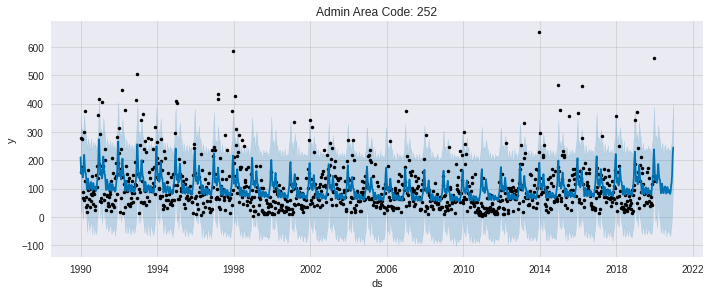

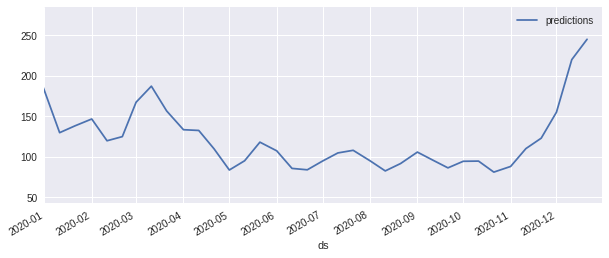

 25%|██▌       | 1/4 [00:04<00:12,  4.29s/it]

Area code: 134


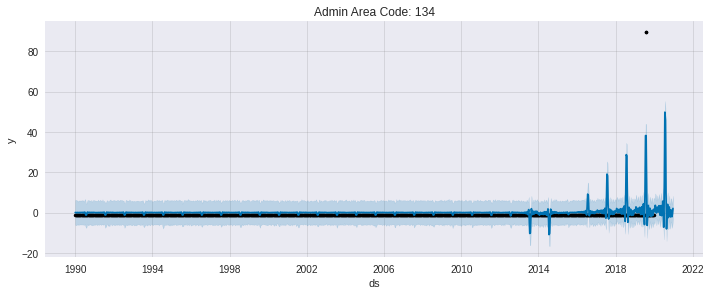

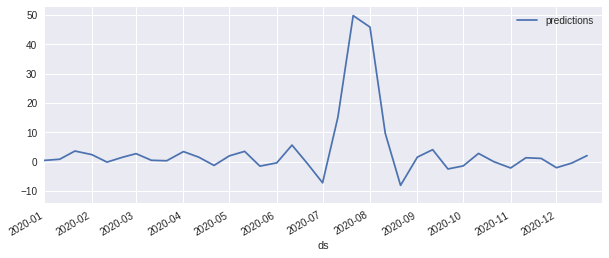

 50%|█████     | 2/4 [00:08<00:08,  4.49s/it]

Area code: 40762


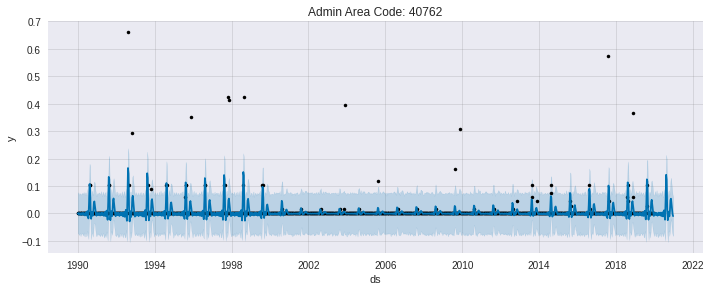

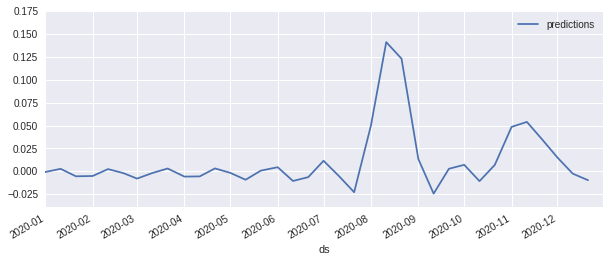

 75%|███████▌  | 3/4 [00:13<00:04,  4.66s/it]

Area code: 273


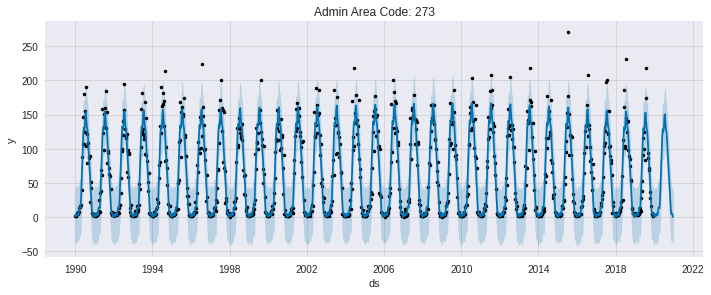

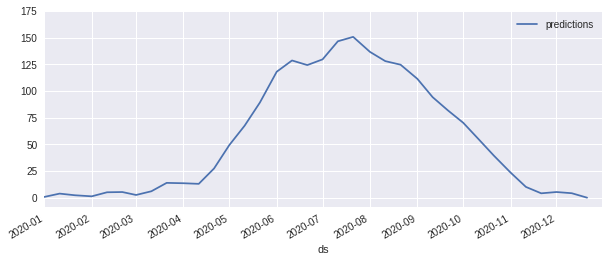

100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


In [ ]:
## predicting on the selected examples

df_predictions = pd.DataFrame(
    columns=['ds', 'yhat', 'AdminCode'])

for area_code in tqdm.tqdm(example_area_codes):
  print('Area code: %.f' % area_code)
  forecast = predicting_prophet_model(df, area_code, future, '2020-01-01', '2020-12-31', plots = True)


In [ ]:
## predicting for all the areas and creating df with predicitons

df_predictions = pd.DataFrame(
    columns=['ds', 'yhat', 'AdminCode'])

for area_code in tqdm.tqdm(area_codes_list):
  forecast = predicting_prophet_model(df, area_code, future, '2020-01-01', '2020-12-31', plots = False)
  prediction = forecast[forecast.ds >= '2020-01-01'][['ds', 'yhat']]
  prediction['AdminCode'] = area_code
    
  df_predictions = df_predictions.append(prediction, ignore_index=True)


100%|██████████| 245/245 [19:09<00:00,  4.69s/it]


In [ ]:
df_predictions.shape

(8820, 3)

In [ ]:
df_predictions = df_predictions.rename(columns={"yhat": "mean_rainfall"})

In [ ]:
df_predictions_3_steps = df_predictions[df_predictions.ds < '2020-02-01']
df_predictions_3_steps.shape

(735, 3)

In [ ]:
# saving dfs
df_predictions.to_csv("df_prediction_rainfall2020.csv")
test_scores_df.to_csv("df_test_scores_2016-2019.csv")
df_predictions_3_steps.to_csv("df_prediction_rainfall_jan2020.csv")